/Users/josegutierrez/Library/Python/3.9/lib/python/site-packages/pandapower/create.py:2369: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  net.trafo.tap_phase_shifter.fillna(False, inplace=True)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



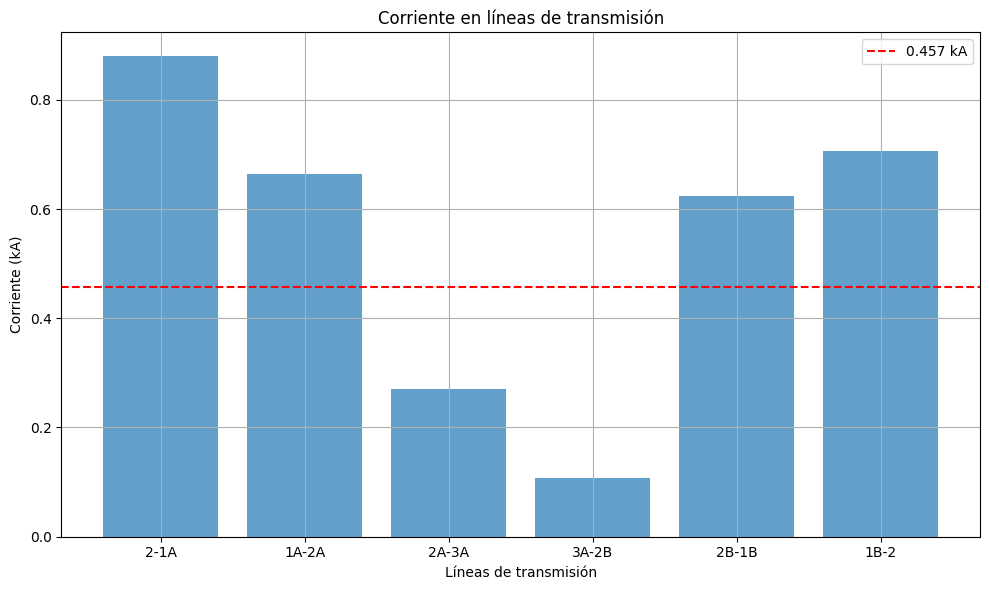

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandapower as pp
import math

# Para la creación de este modelo se asume un sistema trifásico, con voltaje linea-linea de 220[kV],
# analizamos el circuito equivalente para 1 fase

# Definimos los parámetros
f = 50  # frecuencia del sistema en [Hz]

Vg_LL = 110  # voltaje de la línea en [kV]
Imax = 0.457  # corriente máxima en las líneas [kA]

# Respecto a la carga
P = 150  # potencia activa en [MW]
Q = 100  # potencia reactiva en [Mvar]

# Crear red eléctrica
net = pp.create_empty_network()

# Añadir barras
bus1 = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 1", slack=True)  # Barra 1 es designada como slack
bus2 = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 2")  # Barra 2 se conecta la carga
bus1A = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 1A")  # Barra 1A se conecta la carga
bus2A = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 2A")  # Barra 2A se conecta la carga
bus3A = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 3A")  # Barra 3A se conecta la carga
bus2B = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 2B")  # Barra 2B se conecta la carga
bus1B = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 1B")  # Barra 1B se conecta la carga

# Añadir líneas
pp.create_line(net, from_bus=bus2, to_bus=bus1A, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1A, to_bus=bus2A, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus2A, to_bus=bus3A, length_km=20, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus3A, to_bus=bus2B, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus2B, to_bus=bus1B, length_km=30, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1B, to_bus=bus2, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)

# Añadir carga
pp.create_load(net, bus=bus1A, p_mw=0.2*P, q_mvar=0.2*Q)
pp.create_load(net, bus=bus2A, p_mw=0.35*P, q_mvar=0.35*Q)
pp.create_load(net, bus=bus3A, p_mw=0.15*P, q_mvar=0.15*Q)
pp.create_load(net, bus=bus2B, p_mw=0.6*P, q_mvar=0.6*Q)
pp.create_load(net, bus=bus1B, p_mw=0.1*P, q_mvar=0.1*Q)

# Se añade fuente de generación conectada en la barra 1, (1[pu], el voltaje nominal [kV] se define en la barra a la que está conectada)
pp.create_ext_grid(net, bus=bus1, vm_pu=1, va_degree=0.0)

# Se añade transformador de 100 MVA 220/110 kV entre la barra 1 y la barra 2
pp.create_transformer(net, hv_bus=bus2, lv_bus=bus1, name="trafo1", std_type="100 MVA 220/110 kV")
net.trafo.tap_phase_shifter = net.trafo.tap_phase_shifter.fillna(value=False)

# Simular el flujo de carga
pp.runpp(net)

# Obtener las corrientes de las líneas específicas
line_currents = {
    '2-1A': net.res_line.at[0, 'i_ka'],    # Línea 2-1A
    '1A-2A': net.res_line.at[1, 'i_ka'],   # Línea 1A-2A
    '2A-3A': net.res_line.at[2, 'i_ka'],   # Línea 2A-3A
    '3A-2B': net.res_line.at[3, 'i_ka'],   # Línea 3A-2B
    '2B-1B': net.res_line.at[4, 'i_ka'],   # Línea 2B-1B
    '1B-2': net.res_line.at[5, 'i_ka']     # Línea 1B-2
}

import matplotlib.pyplot as plt

# Crear un gráfico de barras para las corrientes de las líneas específicas
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(line_currents)), line_currents.values(), align='center', alpha=0.7)

# Etiquetar las barras con los nombres de las líneas
plt.xticks(range(len(line_currents)), line_currents.keys())

# Agregar etiquetas y título al gráfico
plt.xlabel('Líneas de transmisión')
plt.ylabel('Corriente (kA)')
plt.title('Corriente en líneas de transmisión')

# Agregar una línea segmentada correspondiente a 0.457 kA
plt.axhline(y=0.457, color='r', linestyle='--', label='0.457 kA')

# Mostrar el gráfico
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



/Users/josegutierrez/Library/Python/3.9/lib/python/site-packages/pandapower/create.py:2369: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  net.trafo.tap_phase_shifter.fillna(False, inplace=True)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



      vm_pu  va_degree        p_mw      q_mvar
0  1.000000   0.000000 -228.680543 -551.054588
1  0.844900 -37.986045    0.000000    0.000000
2  0.822316 -38.791163   30.000000   20.000000
3  0.796911 -39.735822   52.500000   35.000000
4  0.783616 -40.261669   22.500000   15.000000
5  0.779637 -40.370589   90.000000   60.000000
6  0.826931 -38.650234   15.000000   10.000000


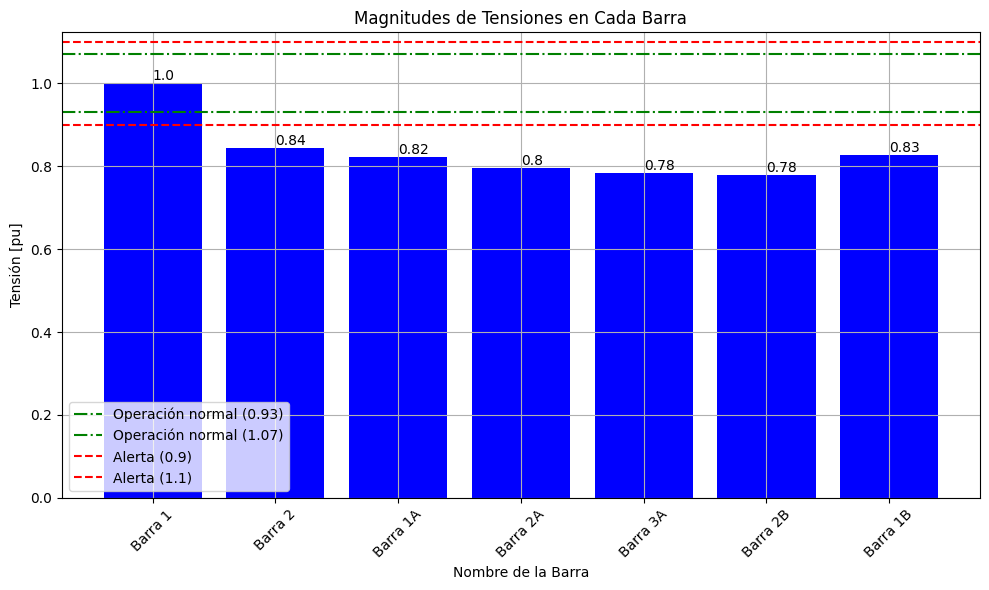

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandapower as pp
import math

# Para la creación de este modelo se asume un sistema trifásico, con voltaje linea-linea de 220[kV],
# analizamos el circuito equivalente para 1 fase

# Definimos los parámetros
f = 50  # frecuencia del sistema en [Hz]

Vg_LL = 110  # voltaje de la línea en [kV]
Imax = 0.457  # corriente máxima en las líneas [kA]

# Respecto a la carga
P = 150  # potencia activa en [MW]
Q = 100  # potencia reactiva en [Mvar]

# Crear red eléctrica
net = pp.create_empty_network()

# Añadir barras
bus1 = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 1", slack=True)  # Barra 1 es designada como slack
bus2 = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 2")  # Barra 2 se conecta la carga
bus1A = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 1A")  # Barra 1A se conecta la carga
bus2A = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 2A")  # Barra 2A se conecta la carga
bus3A = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 3A")  # Barra 3A se conecta la carga
bus2B = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 2B")  # Barra 2B se conecta la carga
bus1B = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 1B")  # Barra 1B se conecta la carga

# Añadir líneas
pp.create_line(net, from_bus=bus2, to_bus=bus1A, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1A, to_bus=bus2A, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus2A, to_bus=bus3A, length_km=20, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus3A, to_bus=bus2B, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus2B, to_bus=bus1B, length_km=30, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1B, to_bus=bus2, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)

# Añadir carga
pp.create_load(net, bus=bus1A, p_mw=0.2*P, q_mvar=0.2*Q)
pp.create_load(net, bus=bus2A, p_mw=0.35*P, q_mvar=0.35*Q)
pp.create_load(net, bus=bus3A, p_mw=0.15*P, q_mvar=0.15*Q)
pp.create_load(net, bus=bus2B, p_mw=0.6*P, q_mvar=0.6*Q)
pp.create_load(net, bus=bus1B, p_mw=0.1*P, q_mvar=0.1*Q)

# Se añade fuente de generación conectada en la barra 1, (1[pu], el voltaje nominal [kV] se define en la barra a la que está conectada)
pp.create_ext_grid(net, bus=bus1, vm_pu=1, va_degree=0.0)

# Se añade transformador de 100 MVA 220/110 kV entre la barra 1 y la barra 2
pp.create_transformer(net, hv_bus=bus2, lv_bus=bus1, name="trafo1", std_type="100 MVA 220/110 kV")
net.trafo.tap_phase_shifter = net.trafo.tap_phase_shifter.fillna(value=False)

# Simular el flujo de carga
pp.runpp(net)

# Imprimir resultados de las barras
print(net.res_bus)

# Obtener resultados de las tensiones en las barras
voltajes = net.res_bus.vm_pu.values
nombres_barras = net.bus.name.values

# Graficar barras de tensiones
plt.figure(figsize=(10, 6))
bars = plt.bar(nombres_barras, voltajes, color='blue')

# Añadir magnitudes numéricas sobre las barras
for bar, valor in zip(bars, voltajes):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(valor, 2), va='bottom')  # Agregar texto encima de la barra

# Agregar línea segmentada para el rango de operación normal (0.93 - 1.07)
plt.axhline(y=0.93, color='green', linestyle='-.', label='Operación normal (0.93)')
plt.axhline(y=1.07, color='green', linestyle='-.', label='Operación normal (1.07)')

# Agregar línea segmentada para el rango de alerta (0.9 - 1.1)
plt.axhline(y=0.9, color='red', linestyle='--', label='Alerta (0.9)')
plt.axhline(y=1.1, color='red', linestyle='--', label='Alerta (1.1)')

plt.title('Magnitudes de Tensiones en Cada Barra')
plt.xlabel('Nombre de la Barra')
plt.ylabel('Tensión [pu]')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
# Obtener las potencias reactivas demandadas desde la barra 2 en adelante
for i in range(1, len(net.bus)):
    bus_name = net.bus.at[i, 'name']
    reactive_power = net.res_bus.q_mvar.at[i]
    print(f"Potencia reactiva demandada en {bus_name}: {reactive_power:.2f} Mvar")

Potencia reactiva demandada en Barra 2: 0.00 Mvar
Potencia reactiva demandada en Barra 1A: 20.00 Mvar
Potencia reactiva demandada en Barra 2A: 35.00 Mvar
Potencia reactiva demandada en Barra 3A: 15.00 Mvar
Potencia reactiva demandada en Barra 2B: 60.00 Mvar
Potencia reactiva demandada en Barra 1B: 10.00 Mvar


/Users/josegutierrez/Library/Python/3.9/lib/python/site-packages/pandapower/create.py:2369: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  net.trafo.tap_phase_shifter.fillna(False, inplace=True)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

/var/folders/sc/qtzrdg213g5dztch4z33_q7w0000gn/T/ipykernel_21902/2436968745.py:69: FutureWarning: Setting an item o

      vm_pu  va_degree        p_mw      q_mvar
0  1.000000   0.000000 -227.063294 -597.932949
1  0.982725 -42.862916    0.000000    0.000000
2  0.964467 -43.480096   30.000000   20.000000
3  0.943957 -44.190567   52.500000   35.000000
4  0.933370 -44.582671   22.500000   15.000000
5  0.930012 -44.656777   90.000000   60.000000
6  0.968400 -43.377511   15.000000   10.000000


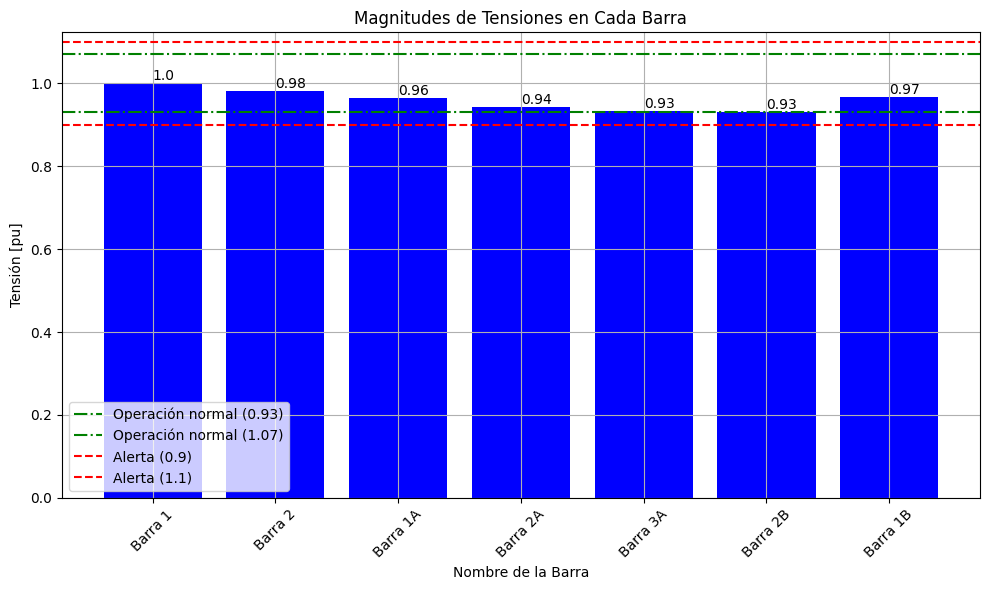

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandapower as pp

# Definición de parámetros
Vg_LL = 110  # Voltaje de la línea en kV
P = 150  # Potencia activa en MW
Q = 100  # Potencia reactiva en Mvar

# Creación de la red eléctrica
net = pp.create_empty_network()

# Añadir barras
bus1 = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 1", slack=True)  # Barra 1 es slack
bus2 = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 2")  # Barra 2 se conecta a la carga
bus1A = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 1A")  # Barra 1A se conecta a la carga
bus2A = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 2A")  # Barra 2A se conecta a la carga
bus3A = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 3A")  # Barra 3A se conecta a la carga
bus2B = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 2B")  # Barra 2B se conecta a la carga
bus1B = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 1B")  # Barra 1B se conecta a la carga

# Añadir transformador entre barra 1 y barra 2
trafo1 = pp.create_transformer(net, hv_bus=bus2, lv_bus=bus1, name="trafo1", std_type="100 MVA 220/110 kV")

# Añadir líneas
pp.create_line(net, from_bus=bus2, to_bus=bus1A, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1A, to_bus=bus2A, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus2A, to_bus=bus3A, length_km=20, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus3A, to_bus=bus2B, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus2B, to_bus=bus1B, length_km=30, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1B, to_bus=bus2, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)

# Añadir carga a las barras
pp.create_load(net, bus=bus1A, p_mw=0.2 * P, q_mvar=0.2 * Q)
pp.create_load(net, bus=bus2A, p_mw=0.35 * P, q_mvar=0.35 * Q)
pp.create_load(net, bus=bus3A, p_mw=0.15 * P, q_mvar=0.15 * Q)
pp.create_load(net, bus=bus2B, p_mw=0.6 * P, q_mvar=0.6 * Q)
pp.create_load(net, bus=bus1B, p_mw=0.1 * P, q_mvar=0.1 * Q)

# Añadir generación a la barra 1
pp.create_ext_grid(net, bus=bus1, vm_pu=1, va_degree=0.0)

# Definir función para verificar si todas las barras están dentro del rango deseado
def todas_barras_dentro_rango(voltajes):
    for v in voltajes:
        if v < 0.93 or v > 1.07:
            return False
    return True

# Inicializar el tap del transformador para que las barras del sistema estén dentro del rango de operación normal (0.93-1.07 pu)
tap_inicial = 1.0
tap_actual = tap_inicial
net.trafo.tap_pos.at[trafo1] = tap_actual

# Simular el flujo de carga inicial
pp.runpp(net)

# Obtener resultados de las tensiones en las barras
voltajes = net.res_bus.vm_pu.values
nombres_barras = net.bus.name.values

# Iterar para ajustar el tap hasta que todas las barras estén dentro del rango
while not todas_barras_dentro_rango(voltajes):
    if any(v < 0.93 for v in voltajes):
        tap_actual += 0.005
    elif any(v > 1.07 for v in voltajes):
        tap_actual -= 0.005

    net.trafo.tap_pos.at[trafo1] = tap_actual
    pp.runpp(net)
    voltajes = net.res_bus.vm_pu.values

# Imprimir resultados de las barras
print(net.res_bus)

# Graficar barras de tensiones
plt.figure(figsize=(10, 6))
bars = plt.bar(nombres_barras, voltajes, color='blue')

# Añadir texto encima de las barras
for bar, valor in zip(bars, voltajes):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(valor, 2), va='bottom')

# Líneas segmentadas para el rango de operación normal (0.93 - 1.07) y alerta (0.9 - 1.1)
plt.axhline(y=0.93, color='green', linestyle='-.', label='Operación normal (0.93)')
plt.axhline(y=1.07, color='green', linestyle='-.', label='Operación normal (1.07)')
plt.axhline(y=0.9, color='red', linestyle='--', label='Alerta (0.9)')
plt.axhline(y=1.1, color='red', linestyle='--', label='Alerta (1.1)')

plt.title('Magnitudes de Tensiones en Cada Barra')
plt.xlabel('Nombre de la Barra')
plt.ylabel('Tensión [pu]')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/Users/josegutierrez/Library/Python/3.9/lib/python/site-packages/pandapower/create.py:2369: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  net.trafo.tap_phase_shifter.fillna(False, inplace=True)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

/var/folders/sc/qtzrdg213g5dztch4z33_q7w0000gn/T/ipykernel_21902/1041935736.py:70: FutureWarning: Setting an item o

      vm_pu  va_degree        p_mw      q_mvar
0  1.000000   0.000000 -226.935744 -584.171809
1  0.993414 -41.234386    0.000000    0.000000
2  0.977366 -41.780511   30.000000   20.000000
3  0.960016 -42.381286   52.500000   35.000000
4  0.953254 -42.635081   22.500000   15.000000
5  0.930010 -43.132004   90.000000   60.000000
6  0.976429 -41.769290   15.000000   10.000000


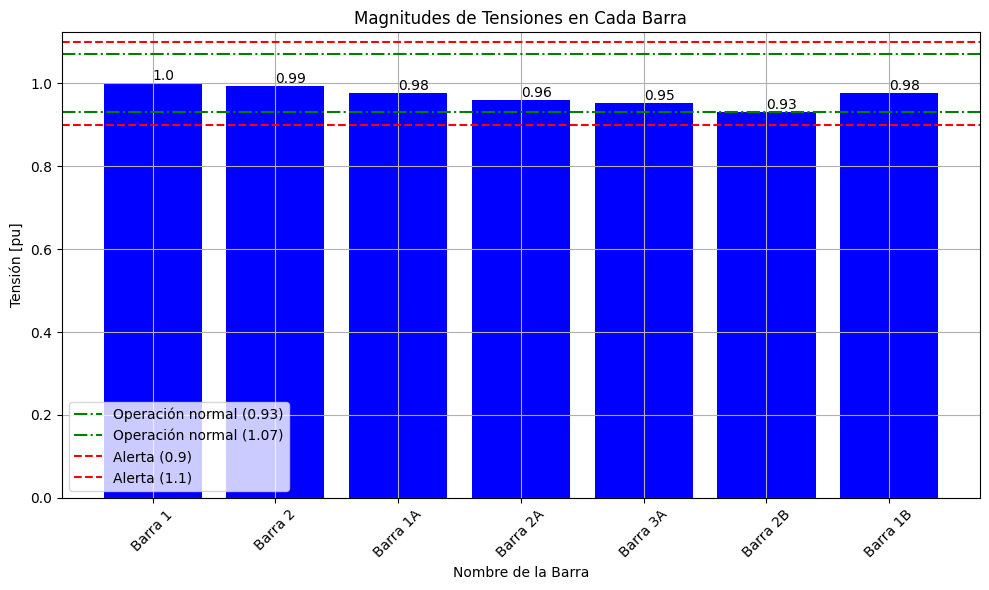

In [21]:
#Ahora desconectando el tramo de línea L3A-2B
import numpy as np
import matplotlib.pyplot as plt
import pandapower as pp

# Definición de parámetros
Vg_LL = 110  # Voltaje de la línea en kV
P = 150  # Potencia activa en MW
Q = 100  # Potencia reactiva en Mvar

# Creación de la red eléctrica
net = pp.create_empty_network()

# Añadir barras
bus1 = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 1", slack=True)  # Barra 1 es slack
bus2 = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 2")  # Barra 2 se conecta a la carga
bus1A = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 1A")  # Barra 1A se conecta a la carga
bus2A = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 2A")  # Barra 2A se conecta a la carga
bus3A = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 3A")  # Barra 3A se conecta a la carga
bus2B = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 2B")  # Barra 2B se conecta a la carga
bus1B = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 1B")  # Barra 1B se conecta a la carga

# Añadir transformador entre barra 1 y barra 2
trafo1 = pp.create_transformer(net, hv_bus=bus2, lv_bus=bus1, name="trafo1", std_type="100 MVA 220/110 kV")

# Añadir líneas
pp.create_line(net, from_bus=bus2, to_bus=bus1A, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1A, to_bus=bus2A, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus2A, to_bus=bus3A, length_km=20, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus3A, to_bus=bus2B, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=False)
pp.create_line(net, from_bus=bus2B, to_bus=bus1B, length_km=30, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1B, to_bus=bus2, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)

# Añadir carga a las barras
pp.create_load(net, bus=bus1A, p_mw=0.2 * P, q_mvar=0.2 * Q)
pp.create_load(net, bus=bus2A, p_mw=0.35 * P, q_mvar=0.35 * Q)
pp.create_load(net, bus=bus3A, p_mw=0.15 * P, q_mvar=0.15 * Q)
pp.create_load(net, bus=bus2B, p_mw=0.6 * P, q_mvar=0.6 * Q)
pp.create_load(net, bus=bus1B, p_mw=0.1 * P, q_mvar=0.1 * Q)

# Añadir generación a la barra 1
pp.create_ext_grid(net, bus=bus1, vm_pu=1, va_degree=0.0)

# Definir función para verificar si todas las barras están dentro del rango deseado
def todas_barras_dentro_rango(voltajes):
    for v in voltajes:
        if v < 0.93 or v > 1.07:
            return False
    return True

# Inicializar el tap del transformador para que las barras del sistema estén dentro del rango de operación normal (0.93-1.07 pu)
tap_inicial = 1.0
tap_actual = tap_inicial
net.trafo.tap_pos.at[trafo1] = tap_actual

# Simular el flujo de carga inicial
pp.runpp(net)

# Obtener resultados de las tensiones en las barras
voltajes = net.res_bus.vm_pu.values
nombres_barras = net.bus.name.values

# Iterar para ajustar el tap hasta que todas las barras estén dentro del rango
while not todas_barras_dentro_rango(voltajes):
    if any(v < 0.93 for v in voltajes):
        tap_actual += 0.005
    elif any(v > 1.07 for v in voltajes):
        tap_actual -= 0.005

    net.trafo.tap_pos.at[trafo1] = tap_actual
    pp.runpp(net)
    voltajes = net.res_bus.vm_pu.values

# Imprimir resultados de las barras
print(net.res_bus)

# Graficar barras de tensiones
plt.figure(figsize=(10, 6))
bars = plt.bar(nombres_barras, voltajes, color='blue')

# Añadir texto encima de las barras
for bar, valor in zip(bars, voltajes):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(valor, 2), va='bottom')

# Líneas segmentadas para el rango de operación normal (0.93 - 1.07) y alerta (0.9 - 1.1)
plt.axhline(y=0.93, color='green', linestyle='-.', label='Operación normal (0.93)')
plt.axhline(y=1.07, color='green', linestyle='-.', label='Operación normal (1.07)')
plt.axhline(y=0.9, color='red', linestyle='--', label='Alerta (0.9)')
plt.axhline(y=1.1, color='red', linestyle='--', label='Alerta (1.1)')

plt.title('Magnitudes de Tensiones en Cada Barra')
plt.xlabel('Nombre de la Barra')
plt.ylabel('Tensión [pu]')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
